## Target Maximization

This section covers budget optimization by maximizing target with the insights from a fitted MMM.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning.optim import TargetMaximizer
from karpiu.planning.common import generate_cost_report

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [3]:
with open("./resource/seasonal/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [4]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.04583,0.04006,0.05170,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.06051,0.05616,0.06488,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.17444,0.16710,0.18166,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.09445,0.08907,0.09999,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.06686,0.06233,0.07167,1.00000,0.00000,0.00000,0.10000
5,s7_fs_cos1,Regular,0.18136,0.17781,0.18502,1.00000,0.00000,0.00000,0.30000
6,s7_fs_cos2,Regular,0.10155,0.09786,0.10518,1.00000,0.00000,0.00000,0.30000
7,s7_fs_sin1,Regular,-0.62595,-0.62962,-0.62236,0.00000,1.00000,0.00000,0.30000
8,s7_fs_sin2,Regular,0.00593,0.00272,0.00937,0.99500,0.00500,0.00000,0.30000
9,s365.25_fs_cos1,Regular,-0.09979,-0.10726,-0.09273,0.00000,1.00000,0.00000,0.30000


In [5]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()

In [6]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    variance_penalty=1e-3,
)
optim_spend_df = maximizer.optimize(maxiter=1000)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -48492.85675504957
            Iterations: 938
            Function evaluations: 146185
            Gradient evaluations: 936


In [7]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [8]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 453606
Total Budget: 453606


### Budget Allocation

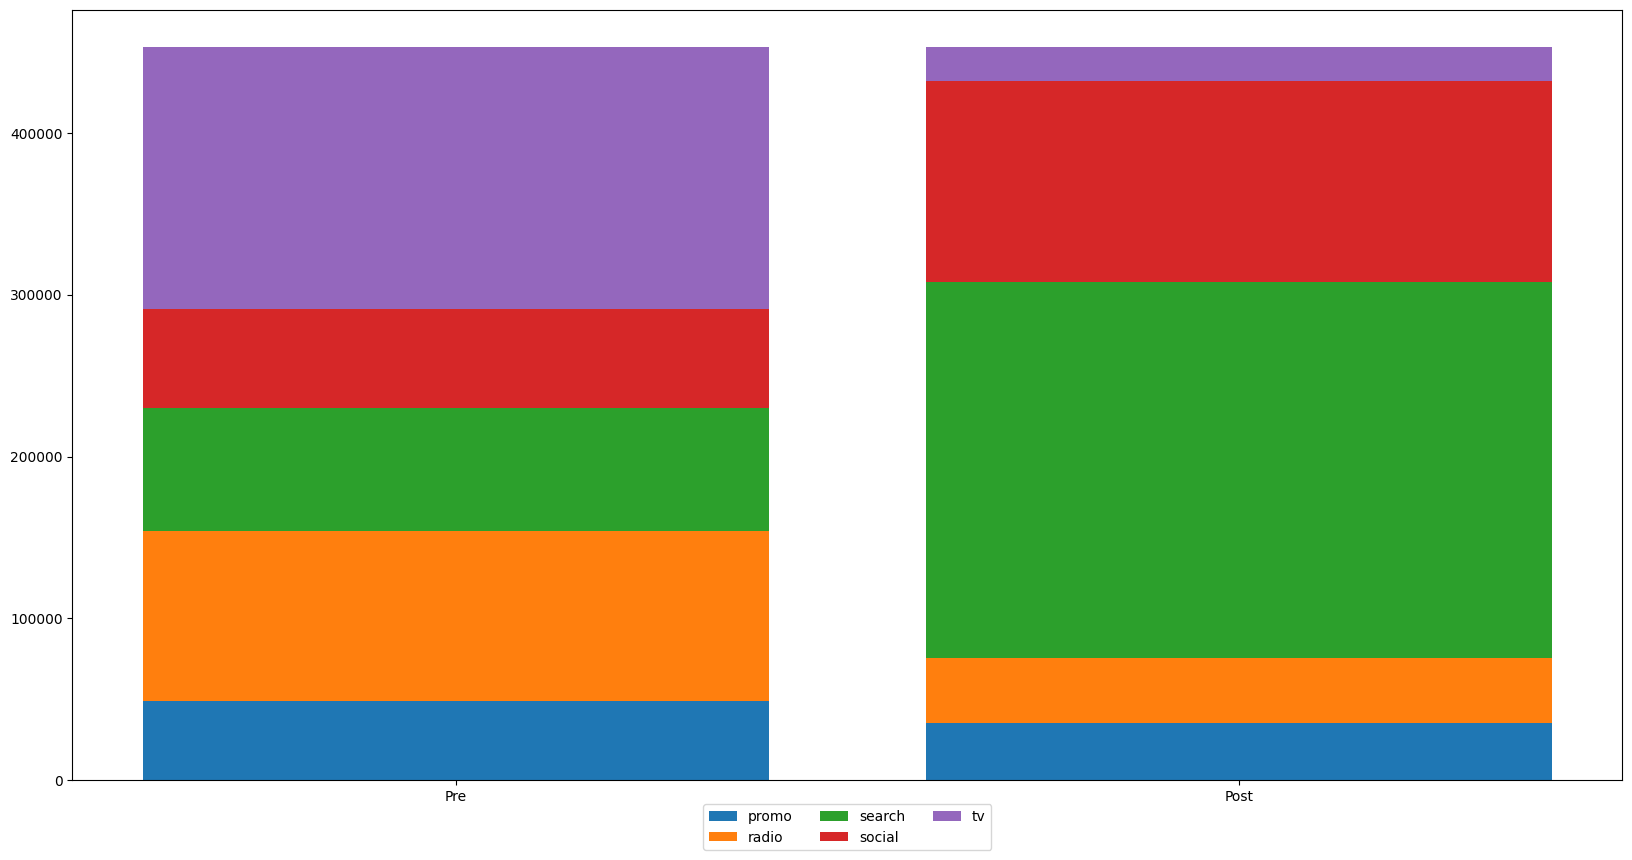

In [9]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
# ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Average and Marginal Cost Change

In [10]:
df = mmm.get_raw_df()

In [11]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,44.64295,29.65934,64.27201,39.61024,48.64000,35.51857
radio,76.94057,38.36386,121.81623,50.22030,105.58500,39.99150
search,29.83018,32.07377,36.76479,47.92253,75.70300,232.34948
social,34.20247,29.83159,47.73425,47.66975,61.33200,124.45978
tv,96.98079,40.51908,144.06620,45.89778,162.34600,21.28668


### Outcome Plot

In [12]:
df = mmm.get_raw_df()
optim_pred = mmm.predict(optim_spend_df)
init_pred = mmm.predict(df)

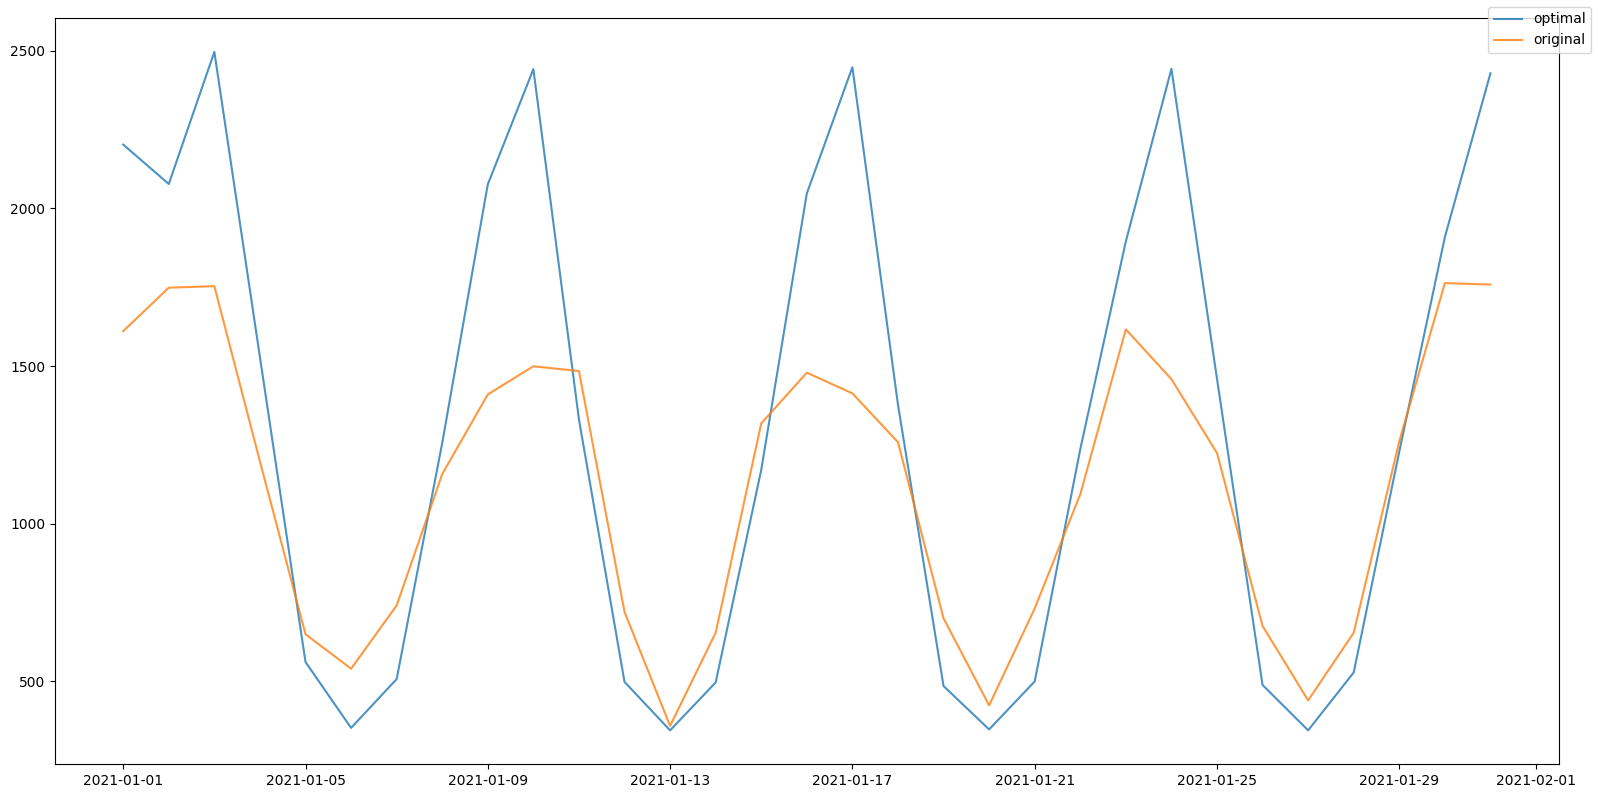

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(
    optim_pred.loc[maximizer.result_mask, "date"].values,
    optim_pred.loc[maximizer.result_mask, "prediction"].values,
    label="optimal",
    alpha=0.8,
)
ax.plot(
    init_pred.loc[maximizer.result_mask, "date"].values,
    init_pred.loc[maximizer.result_mask, "prediction"].values,
    label="original",
    alpha=0.8,
)
fig.legend()
fig.tight_layout();

In [14]:
# check2: total predicted response must be higher than current
total_optim_pred = np.sum(optim_pred.loc[maximizer.result_mask, "prediction"].values)
total_init_pred = np.sum(init_pred.loc[maximizer.result_mask, "prediction"].values)
assert total_optim_pred > total_init_pred